In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 导入数据

In [2]:
#ChinaBank = pd.read_csv('ChinaBank.csv',index_col = 'Date',parse_dates=['Date'])
ChinaBank= pd.read_excel('first.xlsx',index_col='Date',parse_dates=['Date'])
ChinaBank.head()


,Open,High,Low,Close,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
Date,,,,,,,,,,,,,,,,,
2024-01-02,2962.28,-12.66,-0.43,11.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-03,2967.25,4.97,0.17,11.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-04,2954.35,-12.90,-0.43,11.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-05,2929.18,-25.17,-0.85,11.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08,2887.54,-41.65,-1.42,11.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 提取Close列

In [3]:
ChinaBank.index = pd.to_datetime(ChinaBank.index)
sub = ChinaBank.loc['2024-01':'2024-06','Open']

sub.head()

Date
2024-01-02    2962.28
2024-01-03    2967.25
2024-01-04    2954.35
2024-01-05    2929.18
2024-01-08    2887.54
Name: Open, dtype: float64

# 划分训练测试集

In [4]:
train = sub.loc['2024-01':'2024-03']
test = sub.loc['2024-04':'2024-06']

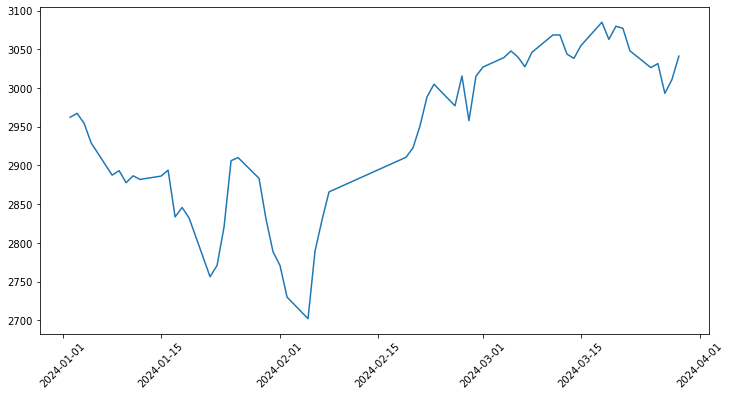

In [5]:
#查看训练集的时间序列与数据(只包含训练集)
plt.figure(figsize=(12,6))
plt.plot(train)
plt.xticks(rotation=45) #旋转45度
plt.show()

# 差分法

In [6]:
#.diff(1)做一个时间间隔
ChinaBank['diff_1'] = ChinaBank['Open'].diff(1) #1阶差分

#对一阶差分数据在划分时间间隔
ChinaBank['diff_2'] = ChinaBank['diff_1'].diff(1) #2阶差分

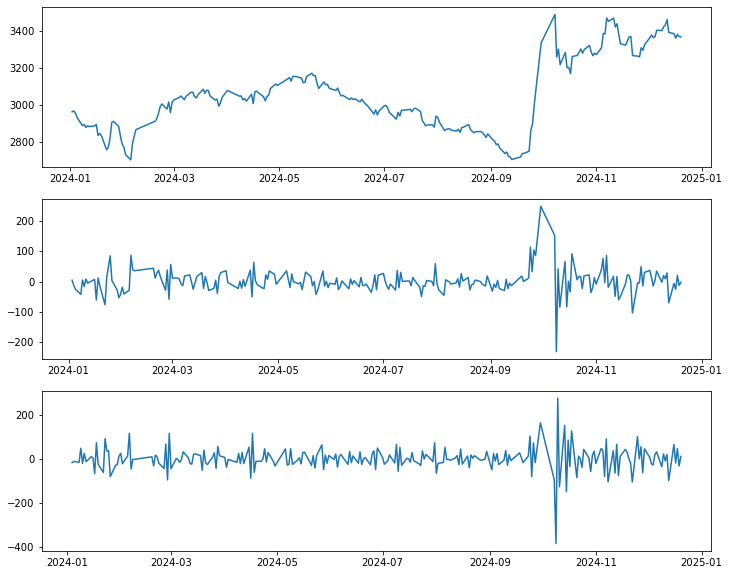

In [7]:
fig = plt.figure(figsize=(12,10))
#原数据
ax1 = fig.add_subplot(311)
ax1.plot(ChinaBank['Open'])
#1阶差分
ax2 = fig.add_subplot(312)
ax2.plot(ChinaBank['diff_1'])
#2阶差分
ax3 = fig.add_subplot(313)
ax3.plot(ChinaBank['diff_2'])
plt.show()

# ADF检验

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

# 计算原始序列、一阶差分序列、二阶差分序列的单位根检验结果
ChinaBank['diff_1'] = ChinaBank['diff_1'].fillna(0)
ChinaBank['diff_2'] = ChinaBank['diff_2'].fillna(0)

timeseries_adf = ADF(ChinaBank['High'].tolist())
timeseries_diff1_adf = ADF(ChinaBank['diff_1'].tolist())
timeseries_diff2_adf = ADF(ChinaBank['diff_2'].tolist())


# 打印单位根检验结果
print('timeseries_adf : ', timeseries_adf)
print('timeseries_diff1_adf : ', timeseries_diff1_adf)
print('timeseries_diff2_adf : ', timeseries_diff2_adf)


timeseries_adf :  (-8.56782820420522, 8.353081248704947e-14, 2, 232, {'1%': -3.458854867412691, '5%': -2.8740800599399323, '10%': -2.573453223097503}, 2238.312718254519)
timeseries_diff1_adf :  (-8.598885506190102, 6.955760658775554e-14, 2, 232, {'1%': -3.458854867412691, '5%': -2.8740800599399323, '10%': -2.573453223097503}, 2238.450930118621)
timeseries_diff2_adf :  (-8.092338926990294, 1.3676189581474675e-12, 10, 224, {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}, 2262.5588577111703)


# 参数确定

In [9]:
import statsmodels.api as sm

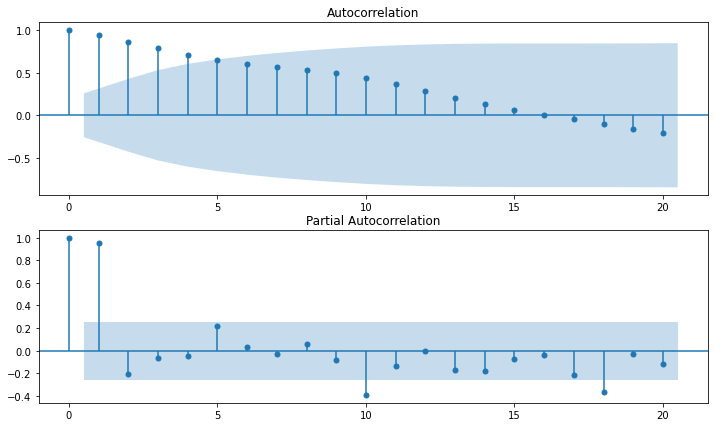

In [10]:
#绘制
fig = plt.figure(figsize=(12,7))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom') # 设置坐标轴上的数字显示的位置，top:显示在顶部  bottom:显示在底部
#fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
#fig.tight_layout()
plt.show()

# 模型建立

In [11]:
#遍历，寻找适宜的参数
import itertools
import numpy as np
import seaborn as sns

In [12]:
#确定pq的取值范围
p_min = 0
d_min = 0
q_min = 0
p_max = 5
d_max = 0
q_max = 5

In [13]:
#Initialize a DataFrame to store the results,，以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    try:
        model = sm.tsa.ARIMA(train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue

c:\Users\86153\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\86153\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [14]:
results_bic

,MA0,MA1,MA2,MA3,MA4,MA5
AR0,NaN,655.869196,NaN,NaN,NaN,NaN
AR1,583.19513,585.149791,588.481865,592.267816,595.944855,599.871747
AR2,584.748727,588.642614,592.439332,596.239168,599.862129,603.861271
AR3,588.534288,NaN,596.73648,598.773658,NaN,607.901743
AR4,592.515558,595.314861,NaN,NaN,NaN,NaN
AR5,595.515534,599.327782,602.26143,NaN,NaN,NaN


In [15]:
#得到结果后进行浮点型转换
results_bic = results_bic[results_bic.columns].astype(float)

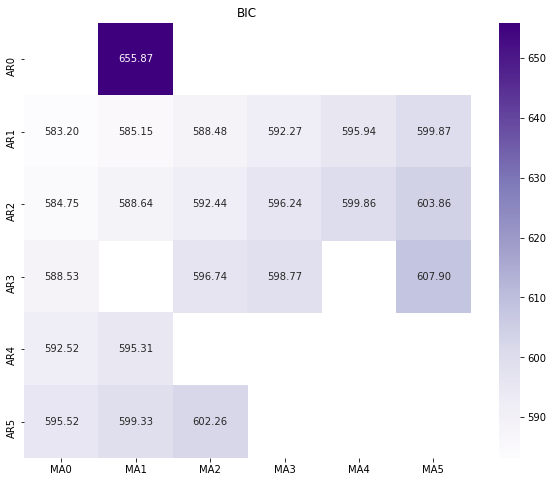

In [16]:
#绘制热力图
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 cmap="Purples"
                 )

ax.set_title('BIC')
plt.show()

In [17]:
results_bic.stack().idxmin()

('AR1', 'MA0')

# 利用模型取p和q的最优值

In [43]:
train_results = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], trend='nc', max_ar=8, max_ma=8)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

c:\Users\86153\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\86153\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn

AIC (2, 0)
BIC (2, 0)


c:\Users\86153\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\86153\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 模型检验

In [18]:
#根据以上求得
p = 2
d = 0
q = 0

In [19]:
model = sm.tsa.ARIMA(train, order=(p,d,q))
results = model.fit()
resid = results.resid #获取残差

c:\Users\86153\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\86153\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

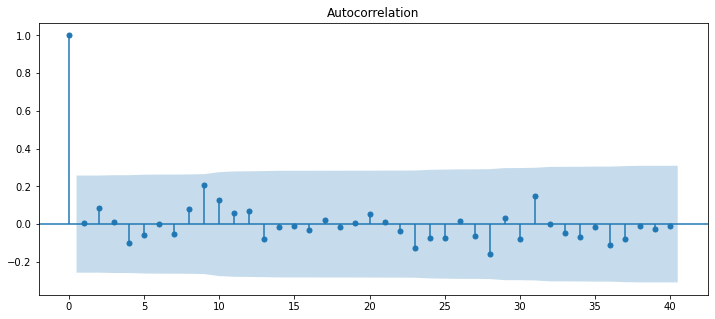

In [20]:
#绘制
#查看测试集的时间序列与数据(只包含测试集)
fig, ax = plt.subplots(figsize=(12, 5))

ax = sm.graphics.tsa.plot_acf(resid, lags=40,ax=ax)

plt.show()

# 模型预测

In [21]:
predict_sunspots = results.predict(dynamic=False)
print(predict_sunspots)

Date
2024-01-02    2958.397151
2024-01-03    2962.060583
2024-01-04    2967.665853
2024-01-05    2951.981581
2024-01-08    2926.010570
2024-01-09    2883.830187
2024-01-10    2898.856282
2024-01-11    2880.007634
2024-01-12    2893.369758
2024-01-15    2886.226178
2024-01-16    2892.083252
2024-01-17    2899.953766
2024-01-18    2829.742755
2024-01-19    2855.940574
2024-01-22    2838.100512
2024-01-23    2754.533612
2024-01-24    2786.742108
2024-01-25    2840.346215
2024-01-26    2927.161660
2024-01-29    2914.342835
2024-01-30    2882.964130
2024-01-31    2828.408562
2024-02-01    2791.510861
2024-02-02    2779.867471
2024-02-05    2737.372289
2024-02-06    2713.904778
2024-02-07    2818.884193
2024-02-08    2846.704635
2024-02-19    2879.617836
2024-02-20    2922.948109
2024-02-21    2927.657096
2024-02-22    2957.252450
2024-02-23    2993.985326
2024-02-26    3005.100875
2024-02-27    2970.041737
2024-02-28    3019.475948
2024-02-29    2946.075363
2024-03-01    3023.052617
2024-03

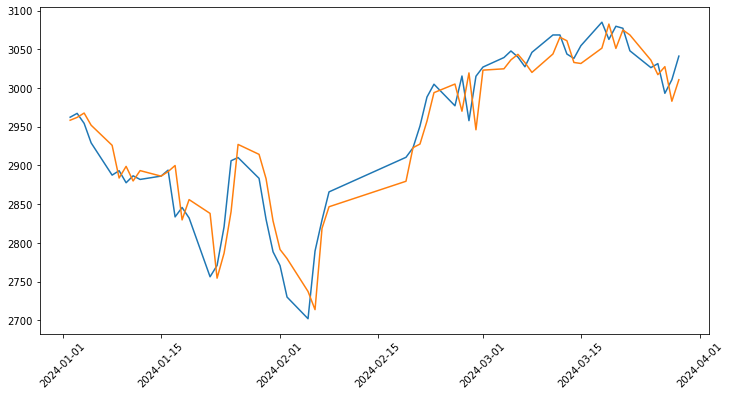

In [22]:
#查看测试集的时间序列与数据(只包含测试集)
plt.figure(figsize=(12,6))
plt.plot(train)
plt.xticks(rotation=45) #旋转45度
plt.plot(predict_sunspots)
plt.show()

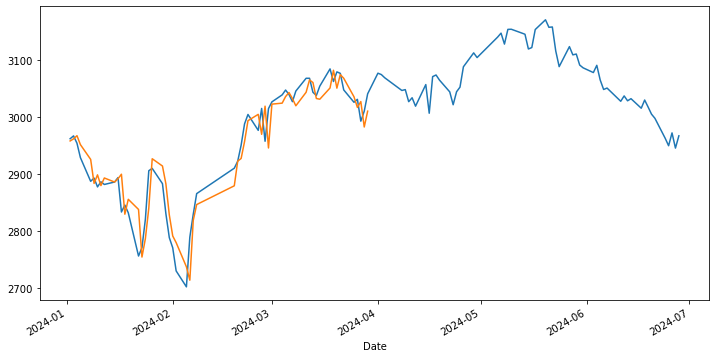

In [23]:
#绘图
fig, ax = plt.subplots(figsize=(12, 6))
ax = sub.plot(ax=ax)
#预测数据
predict_sunspots.plot(ax=ax)
plt.show()